In [1]:
# First we load our location data and drop any duplicated places within documents
import pandas as pd
import shapely.vectorized
import cartopy.io.shapereader as shpreader
import geopandas
import numpy as np
import warnings
import time
import rioxarray
import matplotlib.pyplot as plt


/home/max/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_146456/190250310.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.ht

In [2]:
# Our grid df tells us in which grid cells we have attributable trends in temperature and precipitation
grid_df = pd.read_csv("data/grid_df.csv")[["LAT","LON","temp_da","precip_da"]]
grid_df.head()

,LAT,LON,temp_da,precip_da
0,-88.75,-178.75,NaN,NaN
1,-88.75,-176.25,NaN,NaN
2,-88.75,-173.75,NaN,NaN
3,-88.75,-171.25,NaN,NaN
4,-88.75,-168.75,NaN,NaN


In [3]:
# We load our population data which is also gridded
rds = rioxarray.open_rasterio("data/gpw_v4_population_count_rev11_2020_1_deg.asc")

rds = rds.squeeze().drop("spatial_ref").drop("band")
rds.name = "population"
pop_df = rds.to_dataframe().reset_index()


# And resolve our grid cells to the larger ones we use for temp and precip
pop_df['LAT'] = pop_df['y']//2.5*2.5+1.25
pop_df['LON'] = pop_df['x']//2.5*2.5+1.25
pop_df.loc[pop_df['population']==-9999,"population"]=np.NaN

# We merge the two, so for each grid cell we know how many people live there, and whether there are attributable trends
pop_df = pop_df.merge(grid_df, how="left")
pop_df

,y,x,population,LAT,LON,temp_da,precip_da
0,89.5,-179.5,NaN,88.75,-178.75,NaN,NaN
1,89.5,-178.5,NaN,88.75,-178.75,NaN,NaN
2,89.5,-177.5,NaN,88.75,-176.25,NaN,NaN
3,89.5,-176.5,NaN,88.75,-176.25,NaN,NaN
4,89.5,-175.5,NaN,88.75,-176.25,NaN,NaN
...,...,...,...,...,...,...,...
64795,-89.5,175.5,NaN,-88.75,176.25,NaN,NaN
64796,-89.5,176.5,NaN,-88.75,176.25,NaN,NaN
64797,-89.5,177.5,NaN,-88.75,178.75,NaN,NaN
64798,-89.5,178.5,NaN,-88.75,178.75,NaN,NaN


In [4]:
# We load shapefiles for our countries
countries = geopandas.read_file(shpreader.natural_earth(
    **dict(resolution='50m', category='cultural', name='admin_0_countries')
))
countries.columns

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT',
       'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG',
       'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN',
       'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT',
       'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'WIKIPEDIA', 'FIPS_10_', 'ISO_A2',
       'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID',
       'WOE_ID_EH', 'WOE_NOTE', 'ADM0_A3_IS', 'ADM0_A3_US', 'ADM0_A3_UN',
       'ADM0_A3_WB', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB',
       'NAME_LEN', 'LONG_LEN', 'ABBREV_LEN', 'TINY', 'HOMEPART', 'MIN_ZOOM',
       'MIN_LABEL', 'MAX_LABEL', 'NE_ID', 'WIKIDATAID', 'NAME_AR', 'NAME_BN',
       'NAME_DE', 'NAME_

In [5]:
# We want to resolve our grid of population/attributable trends to the countries they are in

degrees = 1

# We are going to store our shapefile-gridcell index matches here
shp_grid = []

# This is the grid we will work with
yv, xv = np.meshgrid(pop_df.y.unique(), pop_df.x.unique())
for i, place in countries.iterrows(): # Now we go through all the shapes
    # show which gridcell centers are contained inside the shape
    # ignore the warning caused by shapely using an old version of numpy
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        inplace = shapely.vectorized.contains(place.geometry, xv, yv)
    idx = np.argwhere(inplace)
    # Get the number of cells contained in the shape
    number_cells = idx.size/2
    if number_cells == 0:
        # If we have no cell centers in the shape, get the shape center and the cell which contains it
        c = place.geometry.centroid
        lon = c.x//degrees*degrees+degrees*0.5
        lat = c.y//degrees*degrees+degrees*0.5
        pop_df.loc[(pop_df['x']==lon) & (pop_df['y']==lat),"country"] = place["ISO_A3"]
    else:
        for point in idx:
            lon = pop_df.x.unique()[point[0]]
            lat = pop_df.y.unique()[point[1]]
            pop_df.loc[(pop_df['x']==lon) & (pop_df['y']==lat),"country"] = place["ISO_A3"]


In [6]:
# We just check the grid cells with population that were not mapped to countries
mis = pop_df[
    (pd.notna(pop_df["population"])) &
    (pd.isna(pop_df["country"]))
].index

# Thankfully this is not a very large number
f'{pop_df.loc[mis,"population"].sum():,}'

'700,662,784.0'

In [7]:
# Now we create a polygon for each grid cell
from shapely.geometry import Polygon
polygons = []
for i, row in pop_df.loc[mis].iterrows():
    x = row["x"]
    y = row["y"]
    polygons.append(Polygon([
        (x-degrees*0.5,y-degrees*0.5), (x+degrees*0.5, y-degrees*0.5), 
        (x+degrees*0.5,y+degrees*0.5), (x-degrees*0.5, y+degrees*0.5)
    ]))

grid = geopandas.GeoDataFrame({'geometry':polygons,'id': mis})
grid

,geometry,id
0,"POLYGON ((-78.00000 83.00000, -77.00000 83.000...",2262
1,"POLYGON ((-77.00000 83.00000, -76.00000 83.000...",2263
2,"POLYGON ((-76.00000 83.00000, -75.00000 83.000...",2264
3,"POLYGON ((-75.00000 83.00000, -74.00000 83.000...",2265
4,"POLYGON ((-74.00000 83.00000, -73.00000 83.000...",2266
...,...,...
3671,"POLYGON ((-70.00000 -56.00000, -69.00000 -56.0...",52310
3672,"POLYGON ((-69.00000 -56.00000, -68.00000 -56.0...",52311
3673,"POLYGON ((-68.00000 -56.00000, -67.00000 -56.0...",52312
3674,"POLYGON ((-67.00000 -56.00000, -66.00000 -56.0...",52313


In [8]:
# And we overlay this with our list of countries
m = geopandas.overlay(
    grid,
    countries[["geometry","ISO_A3"]], how='intersection'
)
m["area"] = m.area
overlap = m.loc[m.groupby('id')['area'].idxmax()]#['type']
pop_df.loc[overlap["id"],"country"] = overlap["ISO_A3"].values

In [9]:
pop_df[
    (pd.notna(pop_df["population"])) &
    (pd.isna(pop_df["country"]))
]["population"].sum()

1508229.5

In [10]:
# We say that a grid cell has attributable trends if either precipitation or temperature has 
# one of the values +-2 or 3. This means an observed trend that is matched by the 
# climate model scenario with anthropogenic forcing, but significantly different from 
# the scenario with natural forcing only
pop_df["attributable"] = False
pop_df.loc[pop_df["precip_da"].isin([-3,-2,2,3]),"attributable"] = True
pop_df.loc[pop_df["temp_da"].isin([-3,-2,2,3]),"attributable"] = True


In [11]:
# We load the country groupings
groupings = pd.read_excel("data/CountryInfo - 2023.xlsx")
for i, level in enumerate(["Low", "Medium", "High", "Very High"]):
    ls = f"{i}. {level}"
    idx = groupings["HDI Level (2021)"]==level
    groupings.loc[idx, "HDI"] = ls
groupings

,Country Name to use,ISO3,LC Grouping,HDI Level (2021),WHO Region,HDI
0,Aruba,ABW,SIDS,NaN,Americas,NaN
1,Afghanistan,AFG,Asia,Low,Eastern Mediterranean,0. Low
2,Angola,AGO,Africa,Medium,Africa,1. Medium
3,Anguilla,AIA,SIDS,NaN,Americas,NaN
4,Albania,ALB,Europe,High,Europe,2. High
...,...,...,...,...,...,...
217,Samoa,WSM,SIDS,High,Western Pacific,2. High
218,Yemen,YEM,Asia,Low,Eastern Mediterranean,0. Low
219,South Africa,ZAF,Africa,High,Africa,2. High
220,Zambia,ZMB,Africa,Medium,Africa,1. Medium


In [12]:
# And in the first instance group by LC grouping and attributable trend, summing the population in each group
if "ISO3" not in pop_df.columns:
    pop_df = pop_df.merge(groupings, left_on="country", right_on="ISO3", how="left")
    
pop_cgroups = pop_df.groupby(["LC Grouping","attributable"])["population"].sum()
pop_cgroups = pop_cgroups.to_frame().reset_index()
pop_cgroups.to_csv("data/population_exposed.csv", index=False)

In [13]:
# Places are the places we extracted from the documents, with their IDs

places = pd.read_csv("data/clean_places.csv")[["doc_id","country_predicted"]].merge(
    groupings, left_on="country_predicted", right_on="ISO3"
).drop_duplicates(["doc_id","ISO3"])
places

/tmp/ipykernel_146456/3027243177.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  places = pd.read_csv("data/clean_places.csv")[["doc_id","country_predicted"]].merge(


,doc_id,country_predicted,Country Name to use,ISO3,LC Grouping,HDI Level (2021),WHO Region,HDI
0,4963912,CHN,China,CHN,Asia,High,Western Pacific,2. High
5,3388074,CHN,China,CHN,Asia,High,Western Pacific,2. High
9,4351843,CHN,China,CHN,Asia,High,Western Pacific,2. High
10,1046237,CHN,China,CHN,Asia,High,Western Pacific,2. High
14,4090518,CHN,China,CHN,Asia,High,Western Pacific,2. High
...,...,...,...,...,...,...,...,...
370118,2420256,ASM,American Samoa (USA),ASM,SIDS,NaN,Western Pacific,NaN
370120,4182058,ASM,American Samoa (USA),ASM,SIDS,NaN,Western Pacific,NaN
370121,W3212284151,ASM,American Samoa (USA),ASM,SIDS,NaN,Western Pacific,NaN
370122,W2968957814,ASM,American Samoa (USA),ASM,SIDS,NaN,Western Pacific,NaN


In [14]:
# These are the papers in our dataset, labelled according to the 
# climate impact type etc.
df = pd.read_feather("data/attributable_df.feather")
# We merge this with the list of places
df = places.merge(df, left_on="doc_id", right_on="id")
# Attributable studies are those where there are attributable trends
# in temp or precipitation for at least 50% of the area they cover
df["attributable"] = np.where(df["attributable"]>0.5,1,0)
df.head()

,doc_id,country_predicted,Country Name to use,ISO3,LC Grouping,HDI Level (2021),WHO Region,HDI,id,title,...,5 - 4.02. Heatwaves,5 - 4.03. Wildfires,5 - 4.04. Other extreme events,5 - 4.05. Extreme cold,6 - 5.01. Pollution,6 - 5.03. Reduced agricultural & aquaculture productivity,6 - 5.04. Reduced labour and physical capacity,temp_da_simplified,precip_da_simplified,attributable
0,W2006432060,CHN,China,CHN,Asia,High,Western Pacific,2. High,W2006432060,A Method for Screening Climate Change-Sensitiv...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.175713,1
1,W2012486712,CHN,China,CHN,Asia,High,Western Pacific,2. High,W2012486712,Global climate change: Impact of diurnal tempe...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1
2,W2107724144,CHN,China,CHN,Asia,High,Western Pacific,2. High,W2107724144,Transmission of Haemorrhagic Fever with Renal ...,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.177042,1
3,W2107724144,KOR,Republic of Korea,KOR,Asia,Very High,Western Pacific,3. Very High,W2107724144,Transmission of Haemorrhagic Fever with Renal ...,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.177042,1
4,W2107724144,FIN,Finland,FIN,Europe,Very High,Europe,3. Very High,W2107724144,Transmission of Haemorrhagic Fever with Renal ...,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.177042,1


In [15]:
# We can sum the number of studies in each country group, with each attributable status
study_cgroups = df.groupby(["LC Grouping","attributable"])["doc_id"].nunique()
study_cgroups = study_cgroups.reset_index().rename(columns={"doc_id":"studies"})
cgroups = pop_cgroups.merge(study_cgroups)
cgroups

,LC Grouping,attributable,population,studies
0,Africa,False,1.338695e+08,2602
1,Africa,True,1.219284e+09,2440
2,Asia,False,6.655981e+08,5776
3,Asia,True,4.030228e+09,7481
4,Europe,False,2.262457e+06,2493
5,Europe,True,6.868827e+08,4539
6,Northern America,False,7.996261e+07,4933
7,Northern America,True,3.007820e+08,4022
8,Oceania,False,3.084010e+06,1266
9,Oceania,True,2.286342e+07,1139


Text(0, 0.5, '')

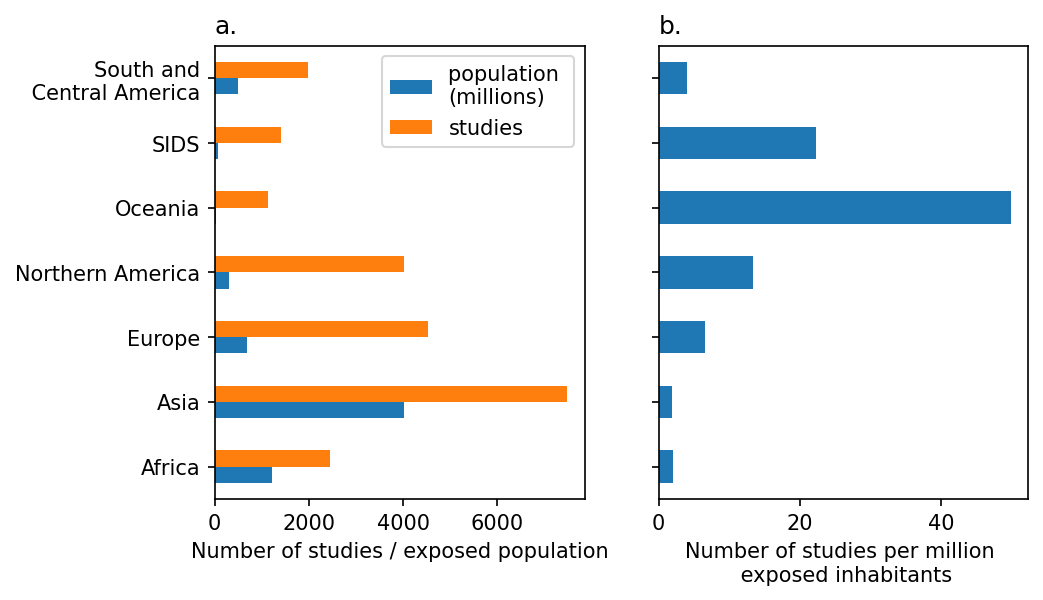

In [16]:
## Now we can plot the number of attributable studies, and the number
# of people living in areas with attributable trends

fig, axs = plt.subplots(1,2, sharey=True, figsize=(7,4), dpi=150)

pdf = cgroups[cgroups["attributable"]].set_index("LC Grouping")
pdf.index = pdf.index.str.replace("and","and\n")
pdf["studies_m"] = pdf["studies"] / (pdf["population"]/1e6)
pdf["studies_m"].plot.barh(ax=axs[1])
pdf["population \n(millions)"] = pdf["population"] / 1e6

pdf[["population \n(millions)","studies"]].plot.barh(ax=axs[0])

#axs[1].set_title("Studies per million\ninhabitants exposed")
#axs[0].set_title("Population exposed to attributable impacts.\nstudies of health impacts of attribuable changes")

axs[0].set_title("a.", loc="left")
axs[1].set_title("b.", loc="left")

axs[0].set_xlabel("Number of studies / exposed population")
axs[1].set_xlabel("Number of studies per million \n exposed inhabitants")

axs[0].legend(loc="best")
axs[0].set_ylabel("")

In [17]:
# We get a list of impacts that were coded
import re
impacts = [x for x in df.columns if re.match("^3 -", x)]
impacts


['3 - 2.01. Food security',
 '3 - 2.02. Mental health and sentiment',
 '3 - 2.03. Cardiorespiratory disease',
 '3 - 2.04. Direct injury and death',
 '3 - 2.05. Infectious diseases',
 '3 - 2.06. Other health impacts',
 '3 - 2.07. Water security',
 '3 - 2.08. Mortality and morbidity',
 '3 - 2.09. Health system capacity']

In [18]:
# And we can produce a version of the table above for each impact type
cgroup_impacts = pd.DataFrame()
for i, c in enumerate(impacts):
    study_impact_cgroups = df.loc[
        (df[c]>=0.5) & 
        (df["attributable"])
    ].groupby(["LC Grouping","attributable"])["doc_id"].nunique()
    study_impact_cgroups = study_impact_cgroups.reset_index().rename(columns={"doc_id":"studies"})
    study_impact_cgroups["impact"] = c
    impact_cgroups = pop_cgroups.merge(study_impact_cgroups)
    cgroup_impacts = pd.concat([cgroup_impacts, impact_cgroups])
    
cgroup_impacts

,LC Grouping,attributable,population,studies,impact
0,Africa,True,1.219284e+09,328,3 - 2.01. Food security
1,Asia,True,4.030228e+09,533,3 - 2.01. Food security
2,Europe,True,6.868827e+08,250,3 - 2.01. Food security
3,Northern America,True,3.007820e+08,251,3 - 2.01. Food security
4,Oceania,True,2.286342e+07,96,3 - 2.01. Food security
...,...,...,...,...,...
2,Europe,True,6.868827e+08,13,3 - 2.09. Health system capacity
3,Northern America,True,3.007820e+08,20,3 - 2.09. Health system capacity
4,Oceania,True,2.286342e+07,22,3 - 2.09. Health system capacity
5,SIDS,True,6.330731e+07,4,3 - 2.09. Health system capacity


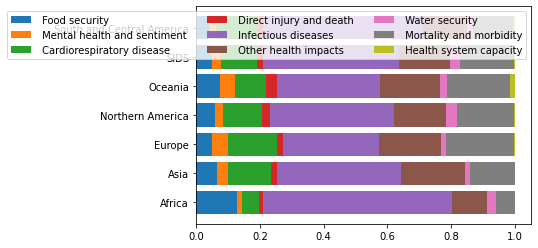

In [19]:
# One option is to show a stacked bar chart, but there are too many categories to easily read with colour
fig, ax = plt.subplots()

left = np.zeros(cgroup_impacts["LC Grouping"].unique().shape[0])

sums = cgroup_impacts.groupby("LC Grouping").sum()

for impact, group in cgroup_impacts.groupby("impact"):
    group = group.groupby("LC Grouping").sum()
    x = group.studies / sums.studies
    ax.barh(group.index, x, left=left, label=impact.split(".")[2])
    left += x

ax.legend(ncols=3)

Text(0, 0.5, '')

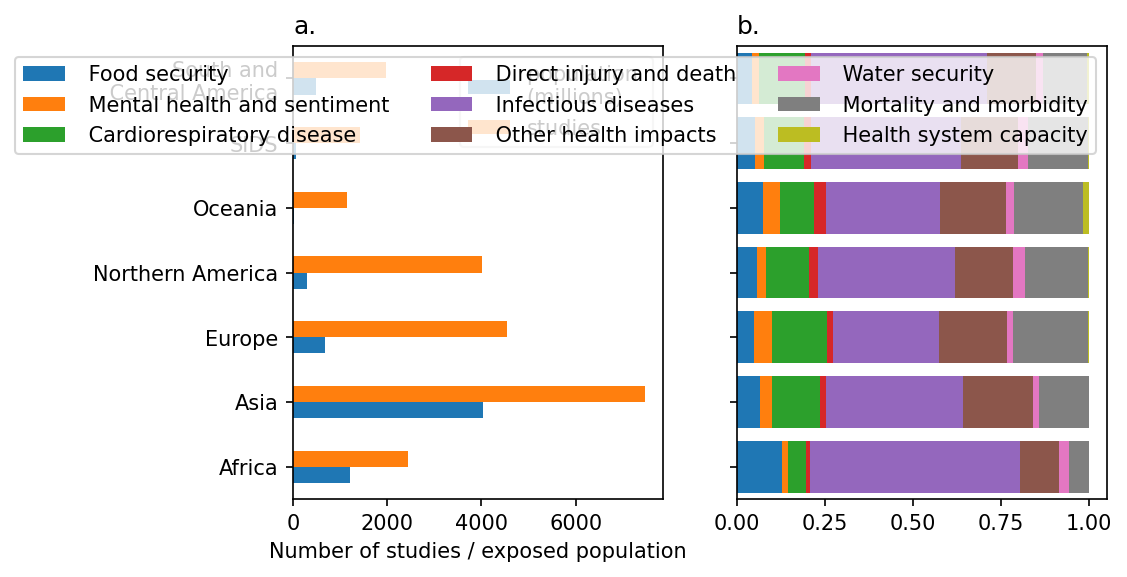

In [20]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(7,4), dpi=150)


pdf = cgroups[cgroups["attributable"]].set_index("LC Grouping")
pdf.index = pdf.index.str.replace("and","and\n")
pdf["studies_m"] = pdf["studies"] / (pdf["population"]/1e6)
pdf["population \n(millions)"] = pdf["population"] / 1e6

pdf[["population \n(millions)","studies"]].plot.barh(ax=axs[0])

#axs[1].set_title("Studies per million\ninhabitants exposed")
#axs[0].set_title("Population exposed to attributable impacts.\nstudies of health impacts of attribuable changes")

axs[0].set_title("a.", loc="left")
axs[1].set_title("b.", loc="left")

axs[0].set_xlabel("Number of studies / exposed population")

ax = axs[1]
left = np.zeros(cgroup_impacts["LC Grouping"].unique().shape[0])

sums = cgroup_impacts.groupby("LC Grouping").sum()

for impact, group in cgroup_impacts.groupby("impact"):
    group = group.groupby("LC Grouping").sum()
    x = group.studies / sums.studies
    ax.barh(group.index, x, left=left, label=impact.split(".")[2])
    left += x

ax.legend(ncols=3)

axs[0].legend(loc="best")
axs[0].set_ylabel("")

[Text(0, 0, 'Africa'),
 Text(0, 1, 'Asia'),
 Text(0, 2, 'Europe'),
 Text(0, 3, 'Northern America'),
 Text(0, 4, 'Oceania'),
 Text(0, 5, 'SIDS'),
 Text(0, 6, 'South and Central America')]

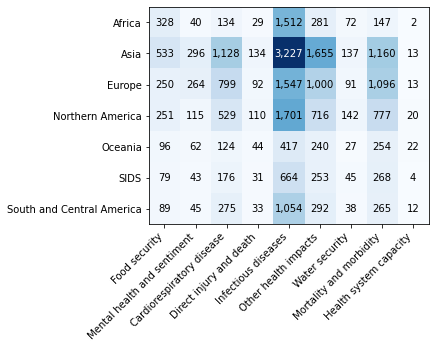

In [21]:
# Another option is a heatmap

regions = cgroup_impacts["LC Grouping"].unique()

m = np.zeros((len(regions),len(impacts)))
for i, (impact, group) in enumerate(cgroup_impacts.groupby("impact")):
    group = group.groupby("LC Grouping").sum()
    m[:,i] = group.studies 
    
fig, ax = plt.subplots()

ax.imshow(m, cmap="Blues")

for i, r in enumerate(regions):
    for j, im in enumerate(impacts):
        if m[i,j] > m.max()*0.6:
            c = "white"
        else:
            c = "black"
        ax.text(j, i, f"{int(m[i,j]):,}", ha="center", va="center",color=c)

ax.set_xticks(np.arange(len(impacts)))
ax.set_xticklabels([x.split(".")[2] for x in impacts],  rotation=45, ha="right")


ax.set_yticks(np.arange(len(regions)))
ax.set_yticklabels(regions)



[Text(0, 0.0, ''),
 Text(0, 1.0, ''),
 Text(0, 2.0, ''),
 Text(0, 3.0, ''),
 Text(0, 4.0, ''),
 Text(0, 5.0, ''),
 Text(0, 6.0, ''),
 Text(0, 7.0, '')]

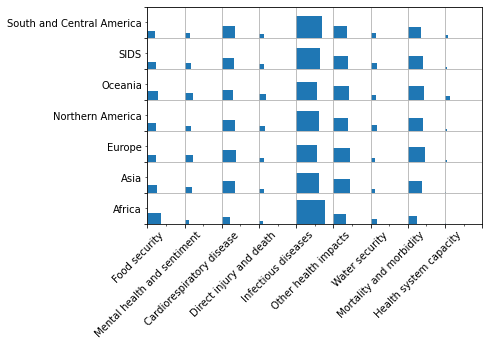

In [22]:
# Alternatively we can do a dot plot with squares

from matplotlib.patches import Circle, Rectangle
from matplotlib.collections import PatchCollection

rm = m/m.sum(axis=1,keepdims=True)

fig, ax = plt.subplots()

patches = []

for i, r in enumerate(regions):
    for j, im in enumerate(impacts):
        l = np.sqrt(rm[i,j])
        c = Rectangle((j,i),l,l)
        patches.append(c)
        
p = PatchCollection(patches)
ax.add_collection(p)
ax.set_xlim(0, len(impacts))
ax.set_ylim(0, len(regions))
ax.grid()

ax.set_xticks(np.arange(len(impacts))+0.5, minor=True)
ax.set_xticklabels([x.split(".")[2] for x in impacts], minor=True, rotation=45, ha="right")
ax.set_xticklabels([])

ax.set_yticks(np.arange(len(regions))+0.5, minor=True)
ax.set_yticklabels(regions, minor=True)
ax.set_yticklabels([])

[Text(0, 0.0, ''),
 Text(0, 1.0, ''),
 Text(0, 2.0, ''),
 Text(0, 3.0, ''),
 Text(0, 4.0, ''),
 Text(0, 5.0, ''),
 Text(0, 6.0, ''),
 Text(0, 7.0, '')]

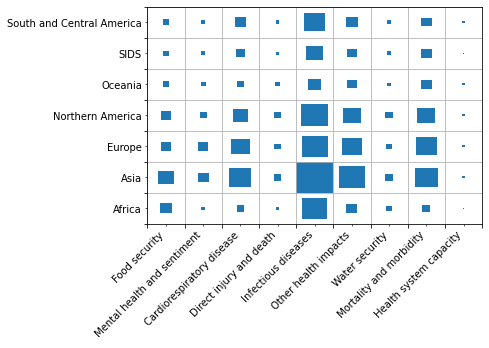

In [23]:
# We can also place these in the middle

rm = m/m.sum(axis=1,keepdims=True)

fig, ax = plt.subplots()

patches = []

for i, r in enumerate(regions):
    for j, im in enumerate(impacts):
        l = np.sqrt(m[i,j]/m.max())
        c = Rectangle((j+(1-l)/2,i+(1-l)/2),l,l)
        patches.append(c)
        
p = PatchCollection(patches)
ax.add_collection(p)
ax.set_xlim(0, len(impacts))
ax.set_ylim(0, len(regions))
ax.grid()

ax.set_xticks(np.arange(len(impacts))+0.5, minor=True)
ax.set_xticklabels([x.split(".")[2] for x in impacts], minor=True, rotation=45, ha="right")
ax.set_xticklabels([])

ax.set_yticks(np.arange(len(regions))+0.5, minor=True)
ax.set_yticklabels(regions, minor=True)
ax.set_yticklabels([])

[Text(0, 0.0, ''),
 Text(0, 1.0, ''),
 Text(0, 2.0, ''),
 Text(0, 3.0, ''),
 Text(0, 4.0, ''),
 Text(0, 5.0, ''),
 Text(0, 6.0, ''),
 Text(0, 7.0, '')]

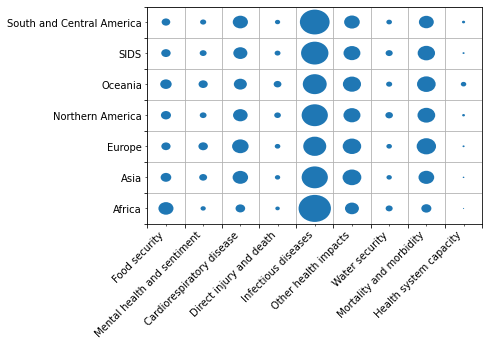

In [24]:
# Or a dot plot where the area of the circle is proportional to the number of studies in each
# region/impact combination

import math
rm = m/m.sum(axis=1,keepdims=True)

fig, ax = plt.subplots()

patches = []

for i, r in enumerate(regions):
    for j, im in enumerate(impacts):
        r = np.sqrt(rm[i,j]/ math.pi) 
        c = Circle((j+0.5,i+0.5),r)
        patches.append(c)
        
p = PatchCollection(patches)
ax.add_collection(p)
ax.set_xlim(0, len(impacts))
ax.set_ylim(0, len(regions))
ax.grid()

ax.set_xticks(np.arange(len(impacts))+0.5, minor=True)
ax.set_xticklabels([x.split(".")[2] for x in impacts], minor=True, rotation=45, ha="right")
ax.set_xticklabels([])

ax.set_yticks(np.arange(len(regions))+0.5, minor=True)
ax.set_yticklabels(regions, minor=True)
ax.set_yticklabels([])

NameError: name 'Normalize' is not defined

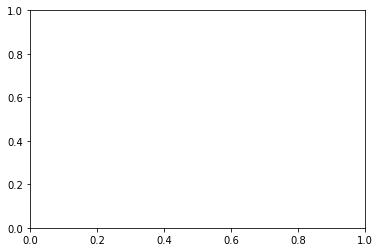

In [25]:
import math
rm = m/m.sum(axis=1,keepdims=True)

fig, ax = plt.subplots()

patches = []


norm = Normalize(vmin=0, vmax=m.max())

for i, r in enumerate(regions):
    for j, im in enumerate(impacts):
        r = np.sqrt(norm(m[i,j])/ math.pi) 
        c = Circle((j+0.5,i+0.5),r)
        patches.append(c)
        
p = PatchCollection(patches)
ax.add_collection(p)
ax.set_xlim(0, len(impacts))
ax.set_ylim(0, len(regions))
ax.grid()

ax.set_xticks(np.arange(len(impacts))+0.5, minor=True)
ax.set_xticklabels([x.split(".")[2] for x in impacts], minor=True, rotation=45, ha="right")
ax.set_xticklabels([])

ax.set_yticks(np.arange(len(regions))+0.5, minor=True)
ax.set_yticklabels(regions, minor=True)
ax.set_yticklabels([])

In [ ]:
# We make nicer labels by adding in the totals for each impact type
impact_labels = []
for i in impacts:
    n = df[(df[i]>0.5) & (df["attributable"])].shape[0]
    impact_labels.append(f'{i.split(".")[2].strip()} ({n:,})')
    
impact_labels

In [ ]:
## And compose our final panel figure with a heatmap and the bar chart

ticksize = 8
title_size = 10

fig, axs = plt.subplots(1,2, sharey=True, figsize=(7,4), gridspec_kw={"width_ratios":[2,1]}, dpi=125)


pdf = cgroups[cgroups["attributable"]].set_index("LC Grouping")
pdf.index = pdf.index.str.replace("and","and\n")
pdf["studies_m"] = pdf["studies"] / (pdf["population"]/1e6)
pdf["population \n(millions)"] = pdf["population"] / 1e6

ax = axs[1]

pdf[["population \n(millions)","studies"]].plot.barh(ax=ax)

#axs[1].set_title("Studies per million\ninhabitants exposed")
#axs[0].set_title("Population exposed to attributable impacts.\nstudies of health impacts of attribuable changes")

ax.set_title("b.", loc="left", fontsize=title_size)


ax.set_xlabel("Number of studies /\n exposed population", fontsize=title_size)


ax.legend(loc="best", fontsize=ticksize)
ax.set_ylabel("")

ax = axs[0]
ax.set_title("a.", loc="left", fontsize=title_size)

ax.imshow(m, cmap="Blues")

for i, r in enumerate(regions):
    for j, im in enumerate(impacts):
        if m[i,j] > m.max()*0.6:
            c = "white"
        else:
            c = "black"
        ax.text(
            j, i, f"{int(m[i,j])}", 
            ha="center", va="center",color=c,
            fontsize=7
        )


ax.set_xticks(np.arange(len(impacts)))
ax.set_xticklabels(impact_labels,  rotation=40, ha="right", fontsize=ticksize)


ax.set_yticks(np.arange(len(regions)))
ax.set_yticklabels([x.replace("and","and\n") for x in regions], fontsize=ticksize)

ax.set_xlabel("Health impact categories", fontsize=title_size)
ax.set_ylabel("World regions", fontsize=title_size)


fig.tight_layout()

axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=ticksize)

In [ ]:
## Now we do the same but grouping by HDI
    
pop_cgroups = pop_df.groupby(["HDI","attributable"])["population"].sum().to_frame().reset_index()

study_cgroups = df.groupby(["HDI","attributable"])["doc_id"].nunique()
study_cgroups = study_cgroups.reset_index().rename(columns={"doc_id":"studies"})
cgroups = pop_cgroups.merge(study_cgroups)
cgroups.head()

In [ ]:
cgroup_impacts = pd.DataFrame()
for i, c in enumerate(impacts):
    study_impact_cgroups = df.loc[
        (df[c]>=0.5) & 
        (df["attributable"])
    ].groupby(["HDI","attributable"])["doc_id"].nunique()
    study_impact_cgroups = study_impact_cgroups.reset_index().rename(columns={"doc_id":"studies"})
    study_impact_cgroups["impact"] = c
    impact_cgroups = pop_cgroups.merge(study_impact_cgroups, how="outer")
    impact_cgroups["impact"] = c
    impact_cgroups = impact_cgroups[impact_cgroups["attributable"]].fillna(0)
    cgroup_impacts = pd.concat([cgroup_impacts, impact_cgroups])
    
cgroup_impacts.head()

In [ ]:
regions = cgroup_impacts["HDI"].unique()

m = np.zeros((len(regions),len(impacts)))
for i, (impact, group) in enumerate(cgroup_impacts.groupby("impact")):
    m[:,i] = group.studies 

In [ ]:
ticksize = 8
title_size = 10

fig, axs = plt.subplots(
    1,2, sharey=True, figsize=(7.5,4), gridspec_kw={
        "width_ratios":[2.5,1]
    }, dpi=125)


pdf = cgroups[cgroups["attributable"]].set_index("HDI")
pdf.index = pdf.index.str.replace("and","and\n")
pdf["studies_m"] = pdf["studies"] / (pdf["population"]/1e6)
pdf["population \n(millions)"] = pdf["population"] / 1e6

ax = axs[1]

pdf[["population \n(millions)","studies"]].plot.barh(ax=ax)

#axs[1].set_title("Studies per million\ninhabitants exposed")
#axs[0].set_title("Population exposed to attributable impacts.\nstudies of health impacts of attribuable changes")

ax.set_title("b.", loc="left", fontsize=title_size)


ax.set_xlabel("Number of studies /\n exposed population", fontsize=title_size)


ax.legend(loc="best", fontsize=ticksize)
ax.set_ylabel("")

ax = axs[0]
ax.set_title("a.", loc="left", fontsize=title_size)

ax.imshow(m, cmap="Blues")

for i, r in enumerate(regions):
    for j, im in enumerate(impacts):
        if m[i,j] > m.max()*0.6:
            c = "white"
        else:
            c = "black"
        ax.text(
            j, i, f"{int(m[i,j])}", 
            ha="center", va="center",color=c,
            fontsize=7
        )


ax.set_xticks(np.arange(len(impacts)))
ax.set_xticklabels(impact_labels,  rotation=40, ha="right", fontsize=ticksize)


ax.set_yticks(np.arange(len(regions)))
ax.set_yticklabels([x.split(".")[1].replace("and","and\n") for x in regions], fontsize=ticksize)

ax.set_xlabel("Health impact categories", fontsize=title_size)
ax.set_ylabel("HDI level (2021)", fontsize=title_size)
ax.set_aspect("auto")


fig.tight_layout()

axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=ticksize)

In [ ]:
# Finally we can do the same, but grouping by each country

df["attributable"] = np.where(df["attributable"]>0.5,True,False)    
pop_cgroups = pop_df.groupby(["ISO3","LC Grouping","HDI Level (2021)","attributable"])["population"].sum().to_frame().reset_index()

cgroup_impacts = pd.DataFrame()
for i, c in enumerate(impacts):
    study_impact_cgroups = df.loc[
        (df[c]>=0.5)
    ].groupby(["ISO3","attributable"])["doc_id"].nunique()
    study_impact_cgroups = study_impact_cgroups.reset_index().rename(columns={"doc_id":"studies"})
    study_impact_cgroups["impact"] = c
    impact_cgroups = pop_cgroups.merge(study_impact_cgroups, how="outer")
    impact_cgroups["impact"] = c
    impact_cgroups = impact_cgroups.fillna(0)
    cgroup_impacts = pd.concat([cgroup_impacts, impact_cgroups])
    
study_impact_cgroups = df.groupby(["ISO3","attributable"])["doc_id"].nunique()
study_impact_cgroups = study_impact_cgroups.reset_index().rename(columns={"doc_id":"studies"})
study_impact_cgroups["impact"] = "Total"
impact_cgroups = pop_cgroups.merge(study_impact_cgroups, how="outer")
impact_cgroups["impact"] = "Total"
impact_cgroups = impact_cgroups.fillna(0)
cgroup_impacts = pd.concat([cgroup_impacts, impact_cgroups])
    
cgroup_impacts.head()

In [ ]:
cgroup_impacts.to_csv("data/country_data.csv", index=False)

In [ ]:
cgroup_impacts[cgroup_impacts["ISO3"]=="USA"]